Acceso a DATOS

In [1]:
from google.colab import drive
drive.mount('/Drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /Drive


In [0]:
import numpy as np
import os
from osgeo import gdal,ogr
from glob import glob
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
Files = glob(r'/Drive/My Drive/tile/*')
for x in Files:
    print (x)

/Drive/My Drive/tile/5. SEÑALIZACION.rar
/Drive/My Drive/tile/TEST
/Drive/My Drive/tile/TRAIN
/Drive/My Drive/tile/medianas_2010-2012.tiff
/Drive/My Drive/tile/MEDIANAS.tif
/Drive/My Drive/tile/Conglomerados.cpg
/Drive/My Drive/tile/Conglomerados.shp.xml
/Drive/My Drive/tile/Conglomerados.dbf
/Drive/My Drive/tile/Conglomerados.shx
/Drive/My Drive/tile/Conglomerados.shp
/Drive/My Drive/tile/Conglomerados.sbn
/Drive/My Drive/tile/Conglomerados.prj
/Drive/My Drive/tile/Conglomerados.sbx


In [4]:
pImag = r'/Drive/My Drive/tile/MEDIANAS.tif'
src_ds=gdal.Open(pImag) 
gt=src_ds.GetGeoTransform()
NroBands = src_ds.RasterCount
#rb = src_ds.GetRasterBand(1)
datos = src_ds.GetRasterBand(1).ReadAsArray()

rows, cols = datos.shape
n_samples = rows*cols
NroBands

6

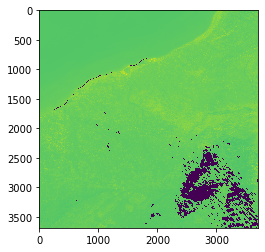

In [5]:
plt.imshow(datos)

In [6]:
shapeFileCorte = r'/Drive/My Drive/tile/Conglomerados.shp'
ds=ogr.Open(shapeFileCorte)
lyr=ds.GetLayer()
pAttributo = 'K10'
pAttrAGB = 'cha_HD'
print("Nro poligonos en Shape:",lyr.GetFeatureCount())
pClasesName = []
       #lee todos los poligonos para extraer el numero de clases en el arreglo 
for feature in lyr:
    pClasesName.append(feature.GetField(pAttributo))
    pClasesName = list(dict.fromkeys(pClasesName)) # remueve Duplicados
print(pClasesName)
proj='GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]]'


Nro poligonos en Shape: 9
[7.0, 1.0, 9.0, 5.0, 6.0, 2.0, 10.0]


In [0]:
def rasterizar_entrenamiento(plyr, pValFilter, pAttrFil, pAttrAGB, rows, cols , geo_transform, projection):
  labeled_pixels = np.zeros((rows, cols)) # imagen base de zeros donde empieza a llenar
  plyr.SetAttributeFilter(pAttrFil + " <> " + "'" + str(pValFilter) + "'")  #### Con este filtra
  print("Nro de Pol Filtrados  <> de",str(pValFilter),":", plyr.GetFeatureCount())
  pClasesAGB = []
  for feature in plyr:
      pClasesAGB.append(feature.GetField(pAttrAGB))
  pClasesAGB = list(dict.fromkeys(pClasesAGB)) # remueve Duplicados si hay dos o mas poligonos con el mismo AGB
  print(pClasesAGB)
  
  #driver = gdal.GetDriverByName('MEM')
  #target_ds = driver.Create('', cols, rows, 1, gdal.GDT_UInt16)
  for val in pClasesAGB:
      plyr.SetAttributeFilter(pAttrAGB + " = " + str(val))  #### Con este filtra
      print("AGB:", val , "nroPol:", plyr.GetFeatureCount())
      driver = gdal.GetDriverByName('MEM')
      target_ds = driver.Create('', cols, rows, 1, gdal.GDT_UInt16)
      target_ds.SetGeoTransform(geo_transform)
      target_ds.SetProjection(projection)
      gdal.RasterizeLayer(target_ds, [1], plyr, burn_values=[val]) ## Asigna el valor de label al poligono 
      #return target_ds
      band = target_ds.GetRasterBand(1)
      labeled_pixels += band.ReadAsArray()
  return labeled_pixels

In [8]:
ImagesTrain = []
for K in pClasesName: # Recorre los ipcc o Kfold
    pima = rasterizar_entrenamiento(lyr, K, pAttributo, pAttrAGB, rows, cols, gt, proj) #rasteriza todos menos el kfold
    ImagesTrain.append(pima)
    ##############   con la imagen rasterizada se realiza clasificacion en esta parte del codigo para cada uno de los K-fold   ##################
    

Nro de Pol Filtrados  <> de 7.0 : 6
[12.3532, 2.28068, 10.8896, 6.44028, 6.48006, 5.95838]
AGB: 12.3532 nroPol: 1
AGB: 2.28068 nroPol: 1
AGB: 10.8896 nroPol: 1
AGB: 6.44028 nroPol: 1
AGB: 6.48006 nroPol: 1
AGB: 5.95838 nroPol: 1
Nro de Pol Filtrados  <> de 1.0 : 8
[4.34956, 13.6518, 2.28068, 10.8896, 6.44028, 6.48006, 5.95838, 4.44512]
AGB: 4.34956 nroPol: 1
AGB: 13.6518 nroPol: 1
AGB: 2.28068 nroPol: 1
AGB: 10.8896 nroPol: 1
AGB: 6.44028 nroPol: 1
AGB: 6.48006 nroPol: 1
AGB: 5.95838 nroPol: 1
AGB: 4.44512 nroPol: 1
Nro de Pol Filtrados  <> de 9.0 : 8
[4.34956, 13.6518, 12.3532, 10.8896, 6.44028, 6.48006, 5.95838, 4.44512]
AGB: 4.34956 nroPol: 1
AGB: 13.6518 nroPol: 1
AGB: 12.3532 nroPol: 1
AGB: 10.8896 nroPol: 1
AGB: 6.44028 nroPol: 1
AGB: 6.48006 nroPol: 1
AGB: 5.95838 nroPol: 1
AGB: 4.44512 nroPol: 1
Nro de Pol Filtrados  <> de 5.0 : 8
[4.34956, 13.6518, 12.3532, 2.28068, 6.44028, 6.48006, 5.95838, 4.44512]
AGB: 4.34956 nroPol: 1
AGB: 13.6518 nroPol: 1
AGB: 12.3532 nroPol: 1
AGB: 2.

imagen ipcc 10


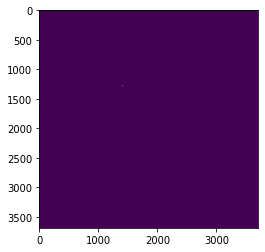

In [9]:
print("imagen ipcc 10")
plt.imshow(ImagesTrain[1]) # muestra la ultima ejecucióm

In [10]:
feature.GetField(pAttrAGB)

4.44512

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.externals import joblib

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Itera las clasificaciones de los K-Fold y las guarda en un arreglo (kClasificaciones)

In [12]:
import datetime
start = datetime.datetime.now()  
print ('Comenzando Clasificacion: %s\n' % (start) )

kClasificaciones = []
# Parametros de la clasificacion
maxDepth=2
RandState=0
NroEstimator=10

for i in range(0,len(ImagesTrain)):
  print("Clasificando K-fold", i+1)
  labeled_pixels=ImagesTrain[i]
  is_train = np.nonzero(labeled_pixels)
  training_labels = labeled_pixels[is_train]
  ###
  datosBandas = src_ds.ReadAsArray()   
  ####
  bands_data = np.dstack(datosBandas)
  training_samples = bands_data[is_train]
  np.isfinite(training_samples)
  _msk=np.sum(np.isfinite(training_samples),1)>1
  training_samples= training_samples[_msk,:]
  training_labels=training_labels[_msk]
  #mascara valores nan por valor no data
  mask_nan=np.isnan(training_samples)
  training_samples[mask_nan]=-9999
  ##Clasificación RF por regresión 
  classifier = RandomForestRegressor(max_depth= maxDepth, random_state=RandState,   n_estimators=NroEstimator)
  classifier.fit(training_samples, training_labels)
  rows, cols, n_bands = bands_data.shape
  n_samples = rows*cols
  flat_pixels = bands_data.reshape((n_samples, n_bands))
  #mascara valores nan por valor no data
  mask_nan=np.isnan(flat_pixels)
  flat_pixels[mask_nan]=-9999
  flat_pixels = bands_data.reshape((n_samples, n_bands))
  result = classifier.predict(flat_pixels)
  classification = result.reshape((rows, cols))
  kClasificaciones.append(classification)

print ('Clasificacion RandomForest Completa --- Duracion: %s\n\n' % (datetime.datetime.now() - start))

Comenzando Clasificacion: 2019-11-15 00:00:34.136485

Clasificando K-fold 1
Clasificando K-fold 2
Clasificando K-fold 3
Clasificando K-fold 4
Clasificando K-fold 5
Clasificando K-fold 6
Clasificando K-fold 7
Clasificacion RandomForest Completa --- Duracion: 0:00:19.234744




In [13]:
kClasificaciones[6]

array([[11.86555142, 11.86555142, 11.86555142, ...,  5.46193487,
        12.69713036, 12.69713036],
       [11.86555142, 11.86555142, 11.86555142, ...,  5.46193487,
         8.81706158, 12.69713036],
       [11.86555142, 11.86555142, 11.86555142, ..., 12.69713036,
        12.69713036, 12.69713036],
       ...,
       [ 6.99393184,  6.99393184,  5.27891515, ...,  6.283896  ,
         6.283896  ,  4.81430556],
       [ 6.99393184,  6.99393184,  6.99393184, ..., 12.69713036,
        12.11313036,  4.90327107],
       [ 5.27891515,  6.99393184,  6.99393184, ..., 12.11313036,
        10.4254673 ,  9.86285861]])

In [14]:
a=kClasificaciones
a=np.asarray(a)
type(a)
a.shape

(7, 3687, 3705)

In [15]:
rows,cols =a[i].shape
print(rows)
print(cols)

3687
3705


In [16]:
dato=a[:,0,0]
dato

array([11.9       , 13.16058177, 10.2434882 , 10.66406857, 10.29348952,
        9.21420635, 11.86555142])

In [17]:
ln, rows, cols =a.shape
print(ln)
print(rows)
print(cols)

7
3687
3705


In [18]:
p1 = np.percentile(dato, 5) 
print(p1)
p2 = np.percentile(dato, 95) 
print(p2)

9.522990905137965
12.782407239819005


In [24]:
percent=np.percentile(dato,q=[5,95])
percent

array([ 9.52299091, 12.78240724])

In [48]:
test5=np.median(dato[np.logical_and(dato>percent[0],dato<percent[1])])
test5

10.66406856584276

In [0]:
for band in bands: 
    bands_data.append(medians[band])
bands_data = np.dstack(bands_data)

array([ 0, 12, 10,  7, 25, 20, 19, 15])

In [0]:
e=np.where(arr <= p1)
print(e)
f=np.where(arr >= p2)
print(p2)

(array([0]),)
23.249999999999996


In [0]:
type(p2)

numpy.float64

In [0]:
#>>> arr = np.arange(12).reshape((3, 4))
#>>> arr
#array([[ 0,  1,  2,  3],
#       [ 4,  5,  6,  7],
#       [ 8,  9, 10, 11]])

#array([[ True, False, False,  True],
#       [False, False,  True, False],
#       [False,  True, False, False]])
#>>> np.extract(condition, arr)
#array([0, 3, 6, 9])

numpy.ndarray

In [0]:
print(np.where((arr > 2) & (arr < 6)))

(array([], dtype=int64),)


In [0]:
condition = (dato <= p1) or (dato >= p2)

ValueError: ignored

In [0]:
kk=np.extract(condition, arr)
kk

array([ 0, 12, 15])

In [0]:
l=0
j=0
for l in range(0,rows):
    for j in range(0,cols):
        a[:,l,j]
        #l+=1
        #j+=1
        #print(a[:,l,j])
        percent=np.percentile(a[:,0,0],q=[5,95])
        


KeyboardInterrupt: ignored

In [0]:
a

array([[[11.9       , 11.9       , 11.9       , ...,  6.23216513,
         10.50789474, 10.0145614 ],
        [11.9       , 11.9       , 11.9       , ...,  6.23216513,
          7.29014699, 11.1       ],
        [11.9       , 11.9       , 11.9       , ..., 10.0145614 ,
         11.5       , 11.9       ],
        ...,
        [11.9       , 11.9       , 11.9       , ...,  7.83114114,
          7.83114114,  6.23216513],
        [11.9       , 12.        , 11.9       , ..., 11.9       ,
         11.4       ,  5.81379778],
        [11.9       , 11.9       , 11.9       , ..., 11.4       ,
         10.50789474, 10.0145614 ]],

       [[13.16058177, 13.16058177, 13.16058177, ...,  5.57785714,
         11.61859043, 12.40343891],
        [13.16058177, 13.16058177, 13.16058177, ...,  5.57785714,
          9.45030303, 12.40343891],
        [13.16058177, 13.16058177, 13.16058177, ..., 12.40343891,
         13.16058177, 13.16058177],
        ...,
        [ 5.96538683,  5.96538683,  5.10175047, ...,  

In [0]:
###Exactitud
vrf = 0
for i in list(range(0,len(mconfu))): 
    for j in list(range(0,len(mconfu))): 
        vrf += mconfu[i][j]  
    #print(mconfu[d][d])
diag = 0
for d in list(range(0,len(mconfu))): 
    #for j in list(range(0,len(mconfu))): 
    diag += mconfu[d][d]  
    #print(mconfu[d][d])

In [0]:
percentClasificaciones=[]
for i in range(0,len(kClasificaciones)):
     for l in range(0,cols):
            percent=np.percentile(kClasificaciones[i][0,l],q=[5,95])

In [0]:
percentClasificaciones=[]
for i in range(0,len(kClasificaciones)):
     for l in range(0,cols):
            percent=np.percentile(kClasificaciones[i][0,l],q=[5,95])
            for j in range(0,rows): 
               percent=np.percentile(kClasificaciones[i][0,j],q=[5,95])
percentClasificaciones.append(percent)
print(percentClasificaciones)

KeyboardInterrupt: ignored

In [0]:
cont=0
percentClasificaciones=[]
for i in range(0,len(kClasificaciones)):
  percent=np.percentile(kClasificaciones[i][0,:],q=[5,95])
  percentClasificaciones.append(percent)
print(percentClasificaciones)

[array([ 6.23216513, 11.9       ]), array([ 5.57785714, 13.16058177]), array([ 6.27896915, 11.98921875]), array([ 4.98728015, 10.66406857]), array([ 5.63955439, 12.86073534]), array([ 5.51056556, 12.69705169]), array([ 5.21193487, 12.69713036])]


In [0]:
percentClasificaciones=[]
for i in range(0,len(kClasificaciones)):
  percent=np.percentile(kClasificaciones[i][0,0],q=[5,95])
  percentClasificaciones.append(percent)
print(percentClasificaciones)

NameError: ignored

In [0]:
percent=np.percentile(kClasificaciones[1],q=[5,95])
print(percent)

[ 4.35386406 13.16058177]


In [0]:
len(kClasificaciones)

7

In [0]:
percent=np.percentile(kClasificaciones[6],q=[5,95])
print(percent)

[ 4.19146552 12.69713036]


Imagen Clasificada Valor de AGB para el Kfold-1


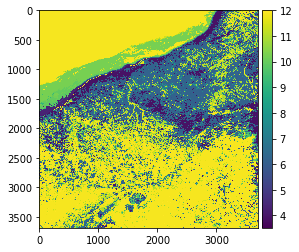

In [0]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
print("Imagen Clasificada Valor de AGB para el Kfold-1")
ax = plt.subplot(111)
im = ax.imshow(kClasificaciones[0])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

In [0]:
type(bands_data)

numpy.ndarray

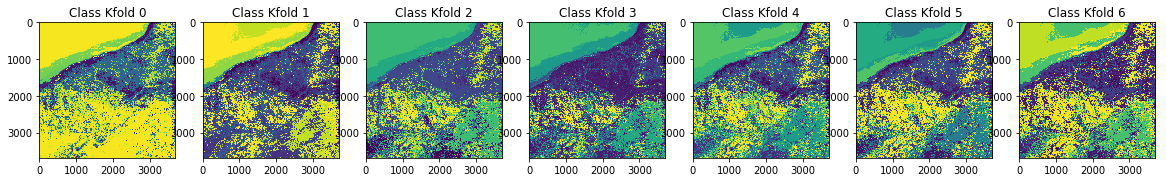

In [0]:
fig, axs = plt.subplots(1, 7, figsize=(20,10))
pCont = 0
for ax, pIma in zip(axs, kClasificaciones):
  ax.set_title('Class Kfold ' + str(pCont))
  ax.imshow(pIma)
  pCont += 1
  

## Validadion de la Clasificacion

In [0]:

def ValidarClass(plyr, pValFilter, pAttrFil, pAttrAGB, geo_transform, projection, kFoldImg):
  rows, cols = kFoldImg.shape
  labeled_pixels = np.zeros((rows, cols)) # imagen base de zeros donde empieza a llenar
  plyr.SetAttributeFilter(pAttrFil + " = " + "'" + str(pValFilter) + "'")  #### Con este filtra
  print("Nro Poligonos para el Kfold", str(pValFilter), " = ", plyr.GetFeatureCount())
  pClasesAGB = []
  for feature in plyr:
      pClasesAGB.append(feature.GetField(pAttrAGB))
  pClasesAGB = list(dict.fromkeys(pClasesAGB)) # remueve Duplicados si hay dos o mas poligonos con el mismo AGB
  for val in pClasesAGB:
      plyr.SetAttributeFilter(pAttrAGB + " = " + str(val))  #### Con este filtra
      print("AGB:", val , "nroPol:", plyr.GetFeatureCount())
      driver = gdal.GetDriverByName('MEM')
      target_ds = driver.Create('', cols, rows, 1, gdal.GDT_UInt16)
      target_ds.SetGeoTransform(geo_transform)
      target_ds.SetProjection(projection)
      gdal.RasterizeLayer(target_ds, [1], plyr, burn_values=[val]) ## Asigna el valor de label al poligono 
      #return target_ds
      band = target_ds.GetRasterBand(1)
      ### Valida el poligono contra los datos del shape
      pImgPol = np.array(band.ReadAsArray())
      pClassImaKfold = np.array(kFoldImg)
      n_samples = rows*cols
      imagRes = np.where(pImgPol.reshape((n_samples, 1)) > 0, pClassImaKfold.reshape((n_samples, 1)), 0) 
      print("AGB en Shp: ", str(val),"Media Calculada:", np.mean(imagRes[imagRes != 0]))
      labeled_pixels += imagRes.reshape((rows, cols))
  return labeled_pixels

valid = ValidarClass(lyr, K, pAttributo, pAttrAGB, gt, proj, kClasificaciones[0])
ImagesVal1 = []
k=10
pContKfold = 0
for K in pClasesName: # Recorre los ipcc o Kfold
    valid = ValidarClass(lyr, K, pAttributo, pAttrAGB, gt, proj, kClasificaciones[pContKfold]) #rasteriza todos menos el kfold
    ImagesVal1.append(valid)
    k=k+1
    pContKfold += 1
    print(k)


Nro Poligonos para el Kfold 10.0  =  1
AGB: 5.95838 nroPol: 1
AGB en Shp:  5.95838 Media Calculada: 6.419884342682408
Nro Poligonos para el Kfold 7.0  =  3
AGB: 4.34956 nroPol: 1
AGB en Shp:  4.34956 Media Calculada: 11.9
AGB: 13.6518 nroPol: 1
AGB en Shp:  13.6518 Media Calculada: 11.9
AGB: 4.44512 nroPol: 1
AGB en Shp:  4.44512 Media Calculada: 6.232165129683926
11
Nro Poligonos para el Kfold 1.0  =  1
AGB: 12.3532 nroPol: 1
AGB en Shp:  12.3532 Media Calculada: 7.88125645035301
12
Nro Poligonos para el Kfold 9.0  =  1
AGB: 2.28068 nroPol: 1
AGB en Shp:  2.28068 Media Calculada: 6.650716693890883
13
Nro Poligonos para el Kfold 5.0  =  1
AGB: 10.8896 nroPol: 1
AGB en Shp:  10.8896 Media Calculada: 6.408605889578631
14
Nro Poligonos para el Kfold 6.0  =  1
AGB: 6.44028 nroPol: 1
AGB en Shp:  6.44028 Media Calculada: 4.4683163404216275
15
Nro Poligonos para el Kfold 2.0  =  1
AGB: 6.48006 nroPol: 1
AGB en Shp:  6.48006 Media Calculada: 5.2488777258316395
16
Nro Poligonos para el Kfold 1

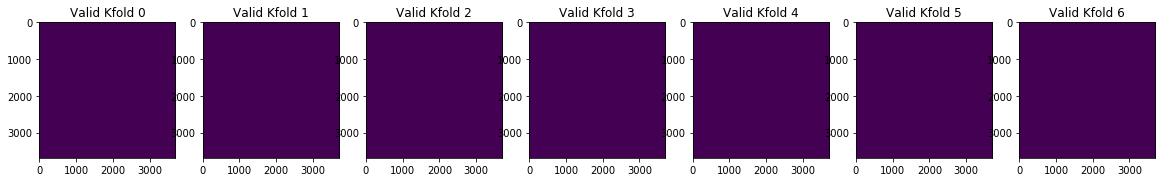

In [0]:
fig, axs = plt.subplots(1, 7, figsize=(20,10))
pCont = 0
for ax, valid in zip(axs, ImagesVal1):
  ax.set_title('Valid Kfold ' + str(pCont))
  ax.imshow(valid)
  pCont += 1

In [0]:
type(kClasificaciones)


list

## Clasificacion individual

In [0]:

labeled_pixels=ImagesTrain[0]
is_train = np.nonzero(labeled_pixels)
training_labels = labeled_pixels[is_train]
###
datosBandas = src_ds.ReadAsArray()
    
bands_data = np.dstack(datosBandas)
training_samples = bands_data[is_train]
np.isfinite(training_samples)
_msk=np.sum(np.isfinite(training_samples),1)>1
training_samples= training_samples[_msk,:]
training_labels=training_labels[_msk]
#mascara valores nan por valor no data
mask_nan=np.isnan(training_samples)
training_samples[mask_nan]=-9999



2976398 2976398


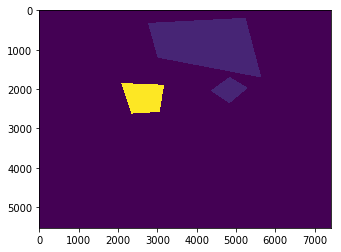

In [0]:
len(training_labels)
len(training_samples)
print(len(training_labels),len(training_samples))
training_labels
plt.imshow(ImagesTrain[1])

In [0]:
##Clasificación RF por regresión 
classifier = RandomForestRegressor(max_depth=2, random_state=0,   n_estimators=10)
classifier.fit(training_samples, training_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [0]:
#joblib.dump(classifier,'modelo02') ### Exporta el modelo PKL

['modelo02']

In [0]:
rows, cols, n_bands = bands_data.shape
n_samples = rows*cols
flat_pixels = bands_data.reshape((n_samples, n_bands))
#mascara valores nan por valor no data
mask_nan=np.isnan(flat_pixels)
flat_pixels[mask_nan]=-9999
flat_pixels = bands_data.reshape((n_samples, n_bands))
result = classifier.predict(flat_pixels)
classification3 = result.reshape((rows, cols))

Imagen Clasificada


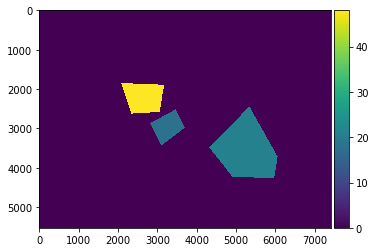

In [0]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
print("Imagen Clasificada")
ax = plt.subplot(111)
im = ax.imshow(ImagesTrain[0])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

In [0]:
classification3[2200][2500]
training_labels[0]

48.0

Imagen Clasificada


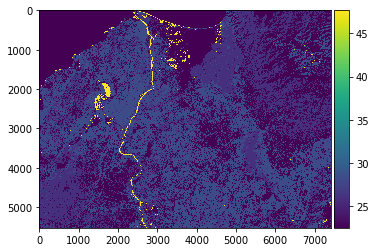

In [0]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
print("Imagen Clasificada")
ax = plt.subplot(111)
im = ax.imshow(classification3)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)